In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from PIL import Image

In [2]:
labels_df = pd.read_csv('/content/SCI_biodiversity_images_and_labels.csv')
labels_df.head()

image_path species_label
0  cropped_images/sci_biosecurity-c3ae90a3d9a22d9...           fox
1  cropped_images/sci_biosecurity-0e1bb2d5f0cfaad...       opossum
2  cropped_images/sci_biosecurity-fe89dfedaa00dc1...       opossum
3  cropped_images/sci_biosecurity-d1a8ad87dd68a02...       opossum
4  cropped_images/sci_biosecurity-8eec8e106a41356...           fox

In [3]:
labels_df['species_label'].unique()

array(['fox', 'opossum', 'rodent', 'bird', 'rat', 'skunk', 'scrub jay',
       'lizard', 'mouse', 'dog', 'vole', 'insect', 'squirrel', 'bat',
       'snake', 'bug', 'rodnet', 'liz', 'butterfly', 'frog',
       'striped skunk'], dtype=object)

In [4]:
# clean label typos and map lower level categorizations to higher level
clean_labels = {'liz':'lizard', 'rodnet':'rodent', 'rat':'rodent','mouse':'rodent',
                'striped skunk': 'skunk', 'bug':'insect', 'butterfly':'insect',
                'scrub jay':'bird', 'squirrel':'rodent',
                'vole':'rodent'}
labels_df['species_label'] = labels_df['species_label'].apply(lambda x: clean_labels.get(x, x))
labels_df['species_label'].unique()

array(['fox', 'opossum', 'rodent', 'bird', 'skunk', 'lizard', 'dog',
       'insect', 'bat', 'snake', 'frog'], dtype=object)

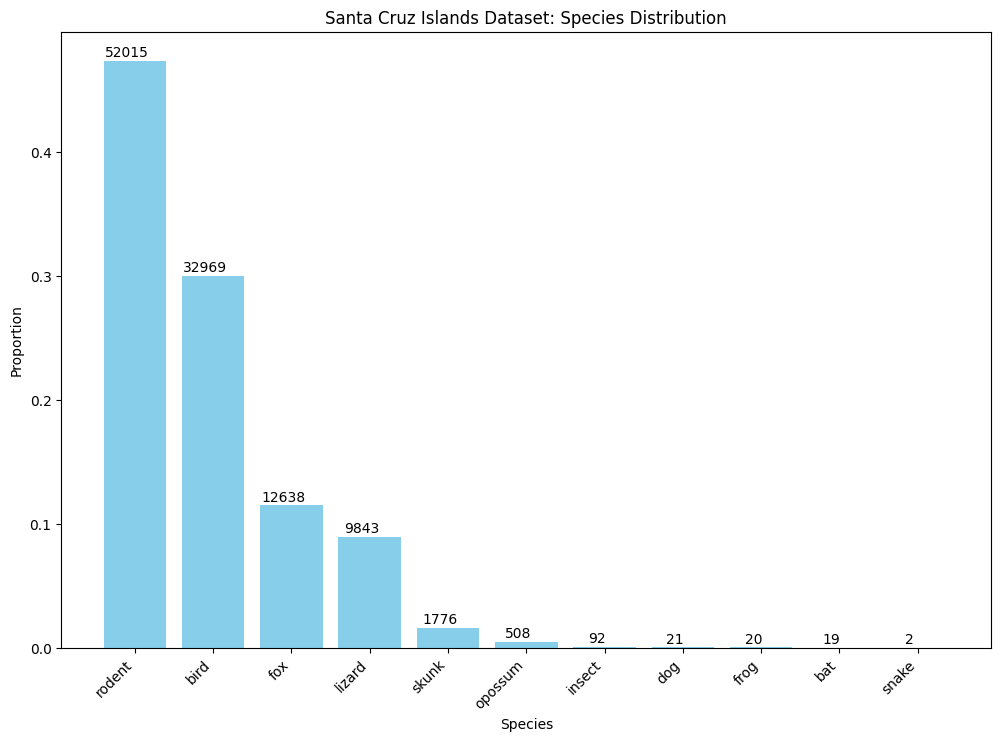

In [5]:
# visualize species distribution
species_proportions = labels_df['species_label'].value_counts(normalize=True).reset_index()
species_proportions.columns = ['species', 'proportion']

plt.figure(figsize=(12, 8))
bars = plt.bar(species_proportions['species'], species_proportions['proportion'], color='skyblue')

# annotating each bar with its count
for bar, count in zip(bars, labels_df['species_label'].value_counts()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.001, f'{count}', ha='center', va='bottom')

plt.xlabel('Species')
plt.ylabel('Proportion')
plt.title('Santa Cruz Islands Dataset: Species Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

In [6]:
!unzip /content/sci_images.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/cropped_images/sci_biosecurity-85887b5d24624f8be8a3a499676d45a9.jpg  
  inflating: /content/cropped_images/26eaa8c4456cfb76394a273612987cc0.jpg  
  inflating: /content/cropped_images/sci_biosecurity-2e9f109b03f94b0b7e3c73a90b58c064.jpg  
  inflating: /content/cropped_images/bdaed811070bc682be4058025cb198b8.jpg  
  inflating: /content/cropped_images/sci_biosecurity-00b08da242910b42433c29f1f3667962.jpg  
  inflating: /content/cropped_images/0708b2ea63d092ce52f38b846d2293b1.jpg  
  inflating: /content/cropped_images/8fefca871a7fa5fce3073601ffac6eaa.jpg  
  inflating: /content/cropped_images/sci_biosecurity-ab7aab5ba23b4db8598e0fbf3ac4ed63.jpg  
  inflating: /content/cropped_images/sci_biosecurity-c2d932a9980b49f75d2ffae9b95bd33d.jpg  
  inflating: /content/cropped_images/sci_biosecurity-cc6ee7bd01a997e548b8dfe5ff05c393.jpg  
  inflating: /content/cropped_images/sci_biosecurity-94b36a26128a4aab431947f172471dd0.jpg  
 

In [7]:
# parameters
height, width, channels = 128, 128, 3
batch_size = 32
epochs = 10

# create data generators
train_df, test_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['species_label'])

datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_dataframe(
    train_df,
    directory='/content/',
    x_col='image_path',
    y_col='image_path',
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='input',
    subset='training'
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    directory='/content/',
    x_col='image_path',
    y_col='image_path',
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='input',
    shuffle = False
)


Found 87922 validated image filenames.
Found 21981 validated image filenames.


In [8]:
print(f'test size: {test_df.shape[0]}')

test size: 21981


In [9]:
# CAE

# Encoder
inputs = tf.keras.Input(shape=(height, width, channels), name='input_layer')

encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
encoded = tf.keras.layers.Conv2D(16, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)

# Decoder
decoded = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
decoded = tf.keras.layers.Conv2DTranspose(channels, 3, strides=2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)

# output layer
outputs = tf.keras.layers.Conv2DTranspose(channels, 3, strides=1, padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

# create the autoencoder model
autoencoder = tf.keras.Model(inputs, outputs, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# train the model
autoencoder.fit(
    train_generator,
    epochs=epochs
)

Epoch 1/10
2748/2748 [==============================] - 118s 39ms/step - loss: 0.0034
Epoch 2/10
2748/2748 [==============================] - 103s 37ms/step - loss: 0.0021
Epoch 3/10
2748/2748 [==============================] - 105s 38ms/step - loss: 0.0018
Epoch 4/10
2748/2748 [==============================] - 108s 39ms/step - loss: 0.0017
Epoch 5/10
2748/2748 [==============================] - 104s 38ms/step - loss: 0.0015
Epoch 6/10
2748/2748 [==============================] - 105s 38ms/step - loss: 0.0012
Epoch 7/10
2748/2748 [==============================] - 106s 38ms/step - loss: 0.0011
Epoch 8/10
2748/2748 [==============================] - 105s 38ms/step - loss: 0.0010
Epoch 9/10
2748/2748 [==============================] - 105s 38ms/step - loss: 9.8920e-04
Epoch 10/10
2748/2748 [==============================] - 106s 39ms/step - loss: 9.4097e-04


In [11]:
def view_reconstructions(df, autoencoder, target_size):
  """
  Function for randomly visualizing images and their CAE reconstructions by species.
  Note, running this function multiple times results in new images plotted.
  """
  species = df['species_label'].unique()
  for sp in species:
    sp_df = df[df['species_label']==sp]
    obs = sp_df.sample(n=1).reset_index()
    img = Image.open(obs['image_path'][0])
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    decoded = autoencoder.predict(img_array, verbose = 0)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img)
    axs[0].set_title('Original')
    axs[1].imshow(decoded[0])
    axs[1].set_title('Reconstructed')
    fig.suptitle(sp)
    plt.tight_layout()
    plt.show()

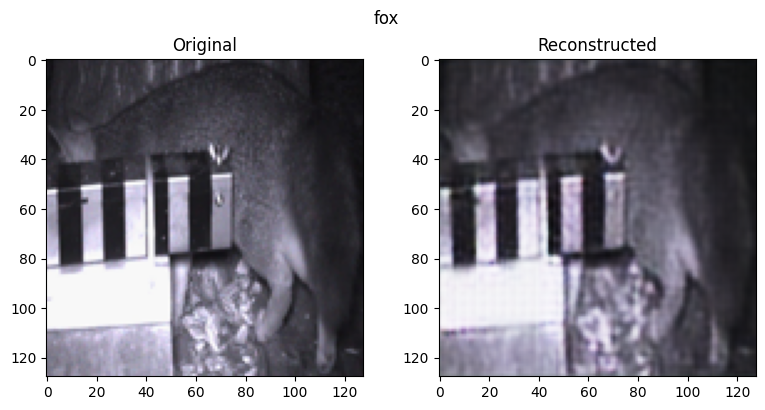

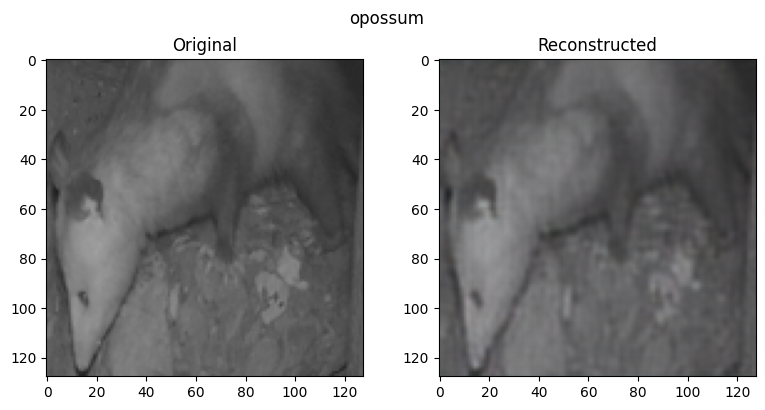

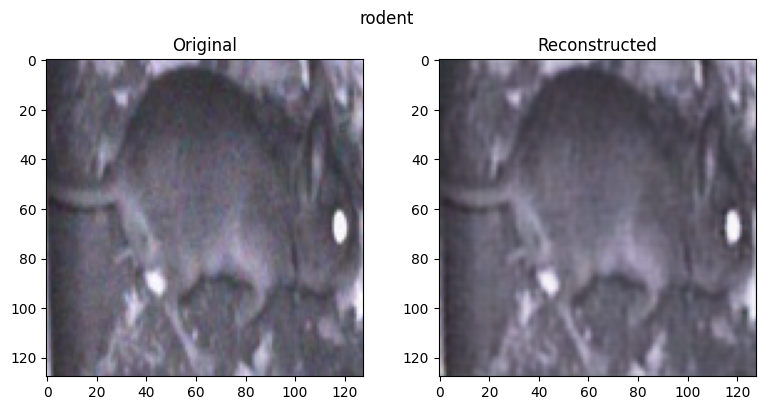

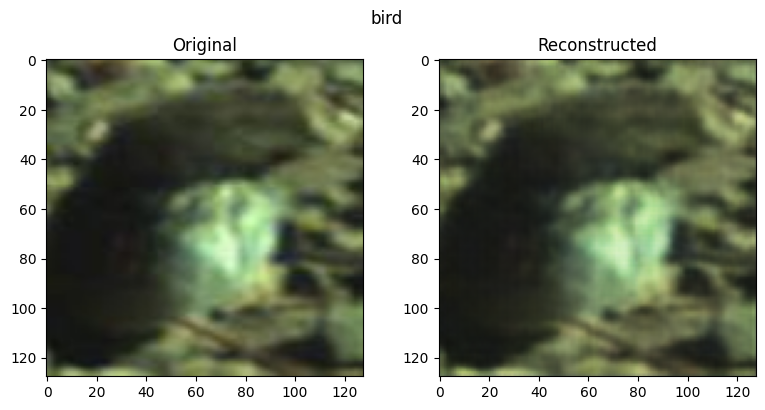

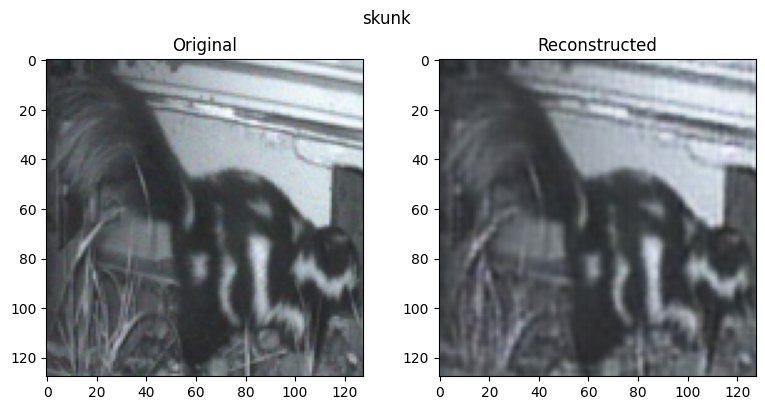

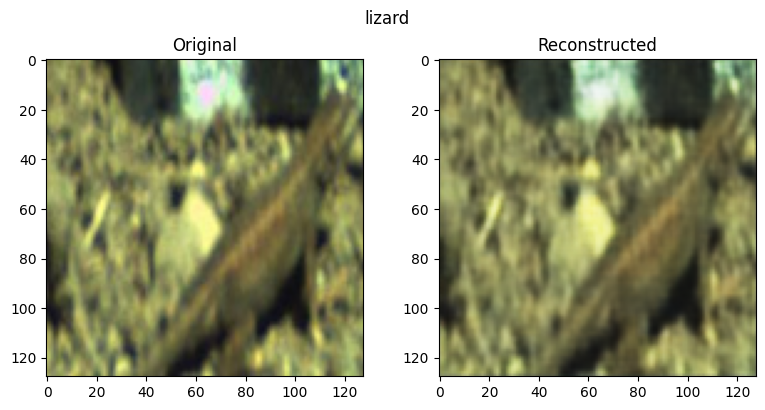

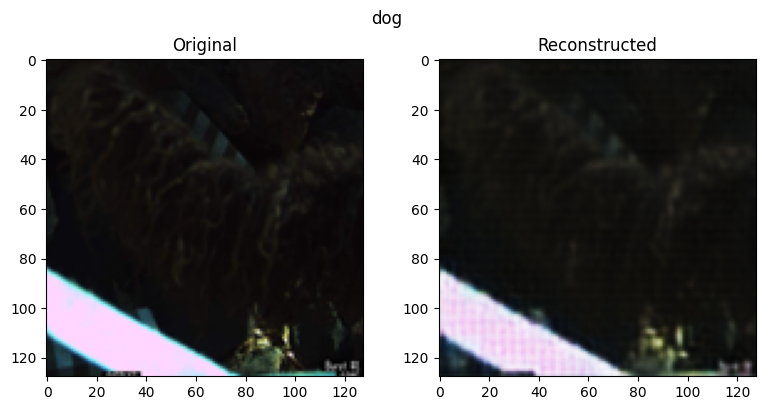

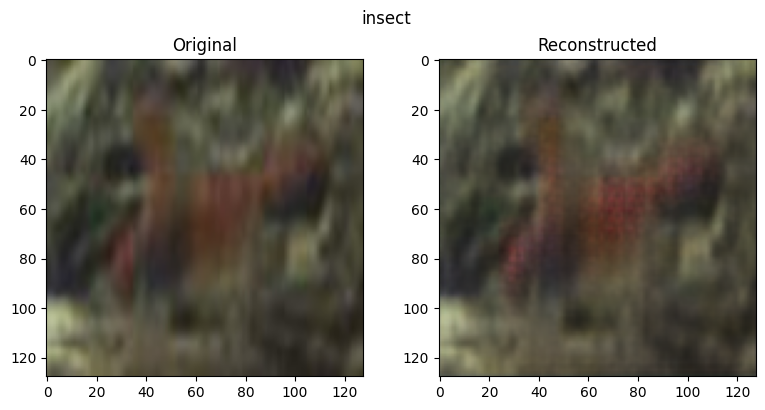

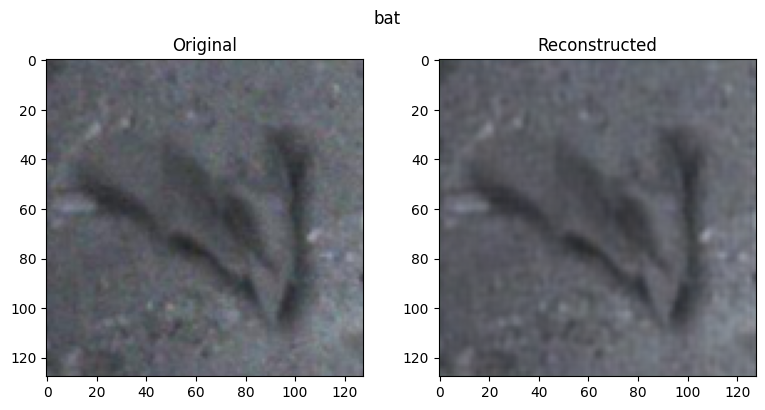

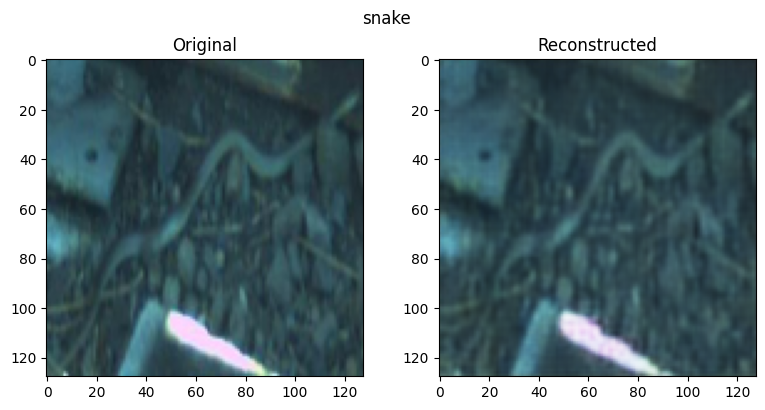

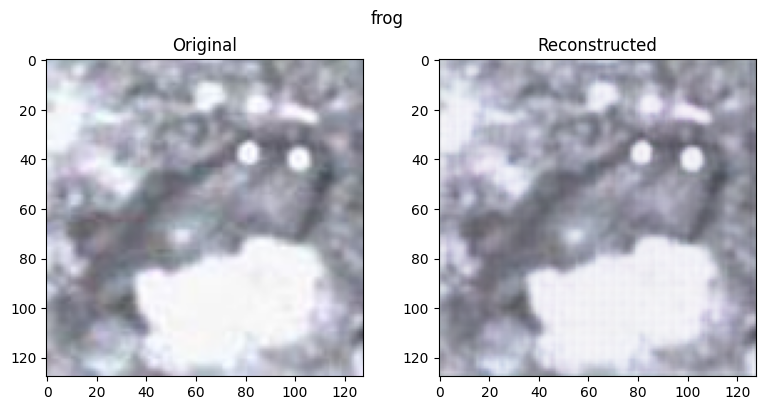

In [12]:
# view random test reconstructions
view_reconstructions(labels_df, autoencoder, (height, width))

In [13]:
autoencoder.save('/content/cae_for_visualization.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
# get all test reconstructions

test_losses = []
test_recons = []
for i in range(len(test_generator)):
    batch = test_generator[i][0]
    reconstruction = autoencoder.predict(batch, verbose = 0)
    mse_batch = np.mean(np.square(batch - reconstruction), axis=(1, 2, 3))
    test_losses.extend(mse_batch)
    test_recons.append(reconstruction)

test_recons = np.concatenate(test_recons, axis=0)
mean_test_mse = np.mean(test_losses)
print(f"Mean Test Loss (MSE): {mean_test_mse}")

Mean Test Loss (MSE): 0.0008239859016612172


In [16]:
# tsne (perplexity = 5 focuses on local structure)
test_recons_2d = test_recons.reshape(test_recons.shape[0],-1)
reducer = TSNE(n_components=2, perplexity = 10, random_state=42)
test_tsne = reducer.fit_transform(test_recons_2d)

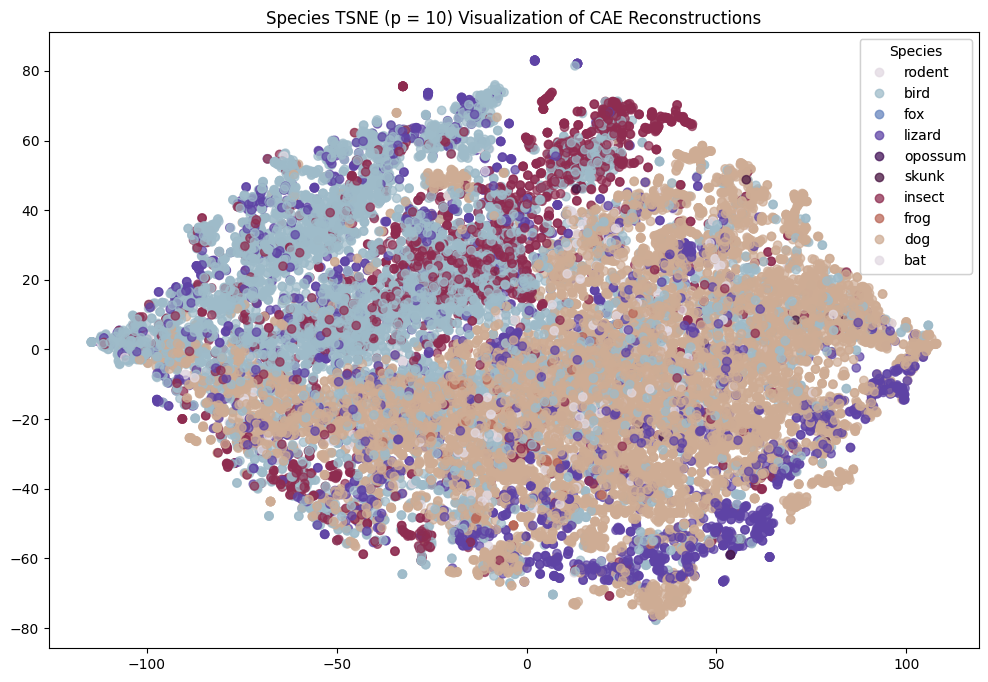

In [18]:
# visualize
species_labels = test_df['species_label'].astype('category').cat.codes
species_names = test_df['species_label'].unique()
species_mapping = {code: name for code, name in zip(range(len(species_names)), species_names)}
species_labels_names = species_labels.map(species_mapping)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(test_tsne[:, 0], test_tsne[:, 1], c=species_labels, alpha=0.7, cmap='twilight')
handles, _ = scatter.legend_elements()
legend1 = plt.legend(handles, species_names, title='Species')
plt.gca().add_artist(legend1)
plt.title('Species TSNE (p = 10) Visualization of CAE Reconstructions')
plt.show()

In [19]:
# tsne
reducer5 = TSNE(n_components=2, perplexity = 5, random_state=42)
test_tsne5 = reducer5.fit_transform(test_recons_2d)

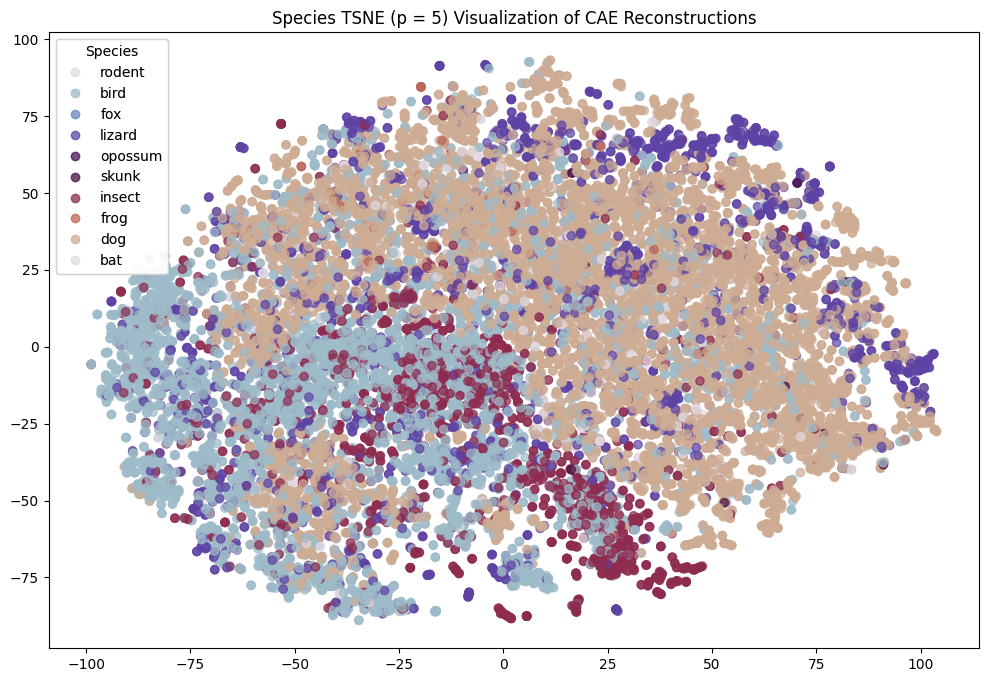

In [20]:
# visualize
plt.figure(figsize=(12, 8))
scatter = plt.scatter(test_tsne5[:, 0], test_tsne5[:, 1], c=species_labels, alpha=0.7, cmap='twilight')
handles, _ = scatter.legend_elements()
legend1 = plt.legend(handles, species_names, title='Species')
plt.gca().add_artist(legend1)
plt.title('Species TSNE (p = 5) Visualization of CAE Reconstructions')
plt.show()

In [21]:
# tsne
reducer50 = TSNE(n_components=2, perplexity = 50, random_state=42)
test_tsne50 = reducer50.fit_transform(test_recons_2d)

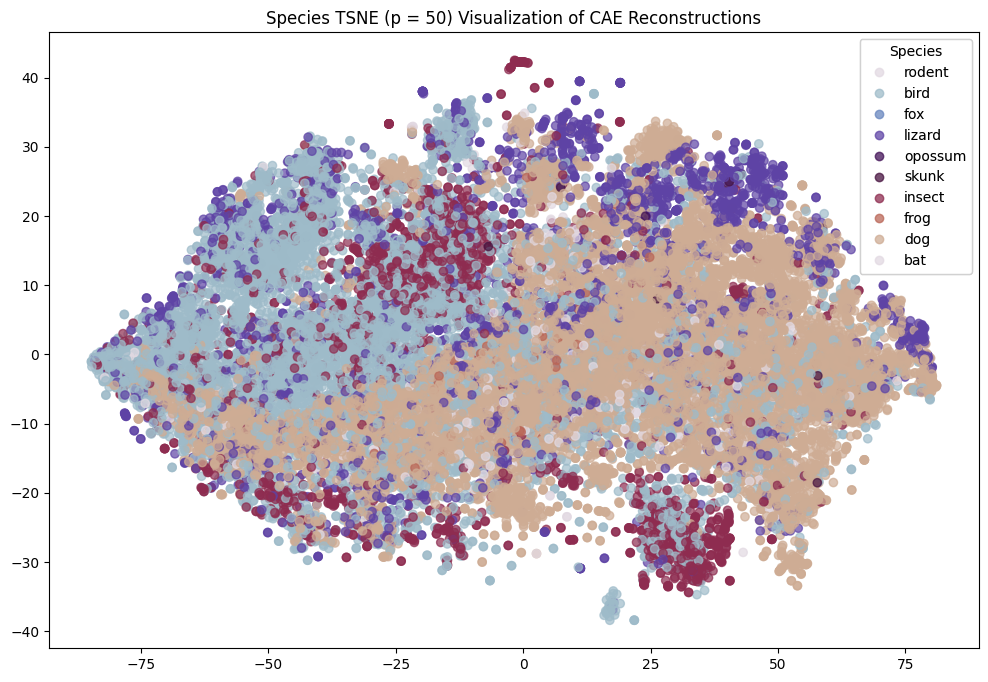

In [22]:
# visualize
plt.figure(figsize=(12, 8))
scatter = plt.scatter(test_tsne50[:, 0], test_tsne50[:, 1], c=species_labels, alpha=0.7, cmap='twilight')
handles, _ = scatter.legend_elements()
legend1 = plt.legend(handles, species_names, title='Species')
plt.gca().add_artist(legend1)
plt.title('Species TSNE (p = 50) Visualization of CAE Reconstructions')
plt.show()